* Creator: Nirvan S P Theethira
* Date: 04/24/2020
* Purpose:  CSCI 5922 Spring group Project: GeoGuessrLSTM
* This file contains scripts to scrape google street view data using the static view API
* Note: This script cannot be run in the current state as it requires a google API key to run. The file structure to save data to also does not match the current structure and a few files have to be modified for a successful run. The scraped data can be found at: https://drive.google.com/drive/folders/17nt3Bvcsq-ndvY-uRddk3ZFQpc8EdCzL?usp=sharing

In [1]:
key = '' #google api key
import requests
import json, os
import urllib.request
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
import shapely
import pickle
import random
import numpy as np
import gmaps
# make sure this points to the file the data is to be saved in
dataDir = "/data/dataAll"

In [2]:
# used to plot collected data points
def plotMap(polyGrid, Loc=[], restrict=[]):
    gPoly = []
    sLoc = []
    sHtext = []
    if len(restrict)==0:
        restrict = list(polyGrid.keys())
        
    for k,v in polyGrid.items():
        if k in restrict:
            gPoly.append(gmaps.Polygon(
                            list(v),
                            stroke_color='red',
                            fill_color='blue'
                            ))
            sLoc.append((v[0][0],v[0][1]))
            sHtext.append(str(k))
    
    if len(Loc)!=0:
        sLoc = []
        sHtext = []
        for k,v in Loc.items():
            if k in restrict:
                sLoc += v
                sHtext += [str(k)+str(i) for i in v]
        
    fig = gmaps.figure(center=(39.50,-98.35), zoom_level=4, map_type='TERRAIN')
    fig.add_layer(gmaps.drawing_layer(features=gPoly))
    fig.add_layer(gmaps.symbol_layer(sLoc,info_box_content = sHtext, scale = 1))
    return fig

243


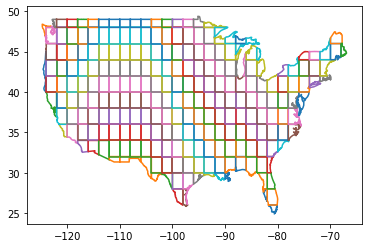

In [3]:
#Load list of polygons containing us map created in grid creation notebook
usaPolyGrid = pickle.load(open("usaPolyGrid.pkl",'rb'))
for i in usaPolyGrid.values():
    plt.plot(i[:,1],i[:,0])
print(len(usaPolyGrid))

In [4]:
plotMap(usaPolyGrid, restrict=[0])

Figure(layout=FigureLayout(height='420px'))

# Street view image scraping

In [21]:
# restrict grids for which data has to collected from. Otherwise data is scraped from all grids
searchGrids = usaPolyGrid.keys()
# searchGrids = list(range(235,244))
print("Seacrchin Grids: {}".format("All" if searchGrids==usaPolyGrid.keys() else searchGrids))

Seacrchin Grids: [235, 236, 237, 238, 239, 240, 241, 242, 243]


* The script below does the heavy lifting in image extraction. It does all the geometry stuff to sample points from each grid and extract street view data by using the google street view API. It also save images in a proper directory structure. Read the documentation for more.

In [22]:
base = 'https://maps.googleapis.com/maps/api/streetview'
ext = '?size=600x300&location={}&fov=100&heading={}&radius={}&pitch=10&key={}'
print("Seacrchin Grids: {}".format("All" if searchGrids==usaPolyGrid.keys() else searchGrids))
for grid,coor in usaPolyGrid.items():        
    poly = Polygon(np.flip(coor))
    minx, miny, maxx, maxy = poly.bounds
    count = 0
    trials = 0
    locList = []
    if grid in searchGrids:
        saveFolder = dataDir + '/{}'.format(grid)
        if os.path.exists(saveFolder)==False:
            os.mkdir(saveFolder)
        locList = os.listdir(saveFolder)
        print("################## Searching grid {} ###################".format(grid))
        print("Save folder {}".format(saveFolder))
        print("Existing locations {}".format(locList))
        while count<20 and trials<10:
            pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            location = str(pnt.y)+','+str(pnt.x)
            if (poly.contains(pnt)) and (location not in locList):
                metaUrl = base + '/metadata' + ext.format(location, 0, 10000, key)
                r = requests.get(metaUrl).json()
                trials += 1
                print("Trial: {}, count: {}".format(trials,count))
                if r['status']=='OK' and poly.contains(Point(r['location']['lng'],r['location']['lat'])):
                    location = str(r['location']['lat'])+','+str(r['location']['lng'])
                    if (location not in locList):
                        print("Valid location found: {}".format(location))
                        locList.append(location)
                        saveFile = saveFolder + "/{}".format(location)
                        if os.path.exists(saveFile)==False:
                            os.mkdir(saveFile)

                        for heading in [0,90,180]:
                            imgUrl = base + ext.format(location, heading, 10000, key)
                            urllib.request.urlretrieve(imgUrl,saveFile+'/{}_{}.jpg'.format(heading,r['date']))
                        count += 1
                        trials = 0
                    else:
                        print("Failed trial {} location exists".format(trials))
                        print("Location {}".format(location))
                else:
                    print("Failed trial {} status or contains".format(trials))
                    print("Location {}".format(location))
        print(locList)
        print("No duplicates: {}".format(len(locList)==len(set(locList))))
        print("########## Final locations for grid {}: {} ############".format(grid, len(locList)))

Seacrchin Grids: [235, 236, 237, 238, 239, 240, 241, 242, 243]
################## Searching grid 235 ###################
Save folder /home/nirvan/Desktop/github/GeoguessrAI/infoExtraction/data/235
Existing locations ['43.7180304,-72.2510664', '43.6688744,-72.6358626', '43.5354013,-72.47627330000002', '42.5011761,-72.6436827', '42.73581568222245,-73.27816861012279', '43.35093058238161,-72.76004983465286', '43.9695509,-72.66771', '43.0803054409276,-72.53614092579647', '43.2805377,-73.0079952', '43.51679786715495,-73.24110623666695', '43.79921180243207,-73.07830777188775', '42.74714911744672,-73.20667963344106', '43.10344919009461,-72.32204967445601', '43.349199,-72.7255889', '43.9455325,-72.8405303', '42.04664844904514,-73.05874051076067', '42.50285439953971,-73.86354486047067', '42.3031759,-72.83125160000002', '43.84346637411877,-73.71308372711118', '42.9228385,-73.4160671']
Trial: 1, count: 0
Valid location found: 43.79777162022417,-73.87744650468017
Trial: 1, count: 1
Valid location f

Trial: 1, count: 0
Valid location found: 41.86300102743252,-71.82109051826845
Trial: 1, count: 1
Valid location found: 41.750088200985,-70.67137850867645
Trial: 1, count: 2
Valid location found: 41.97185678784678,-71.3378526218646
Trial: 1, count: 3
Valid location found: 41.44222872405892,-71.7164823054048
Trial: 1, count: 4
Valid location found: 41.5683599,-70.5158328
Trial: 1, count: 5
Valid location found: 41.8506724,-71.1169037
Trial: 1, count: 6
Valid location found: 41.65756727995777,-70.95159908425725
Trial: 1, count: 7
Valid location found: 41.7505422,-71.5826113
Trial: 1, count: 8
Valid location found: 41.92976261975407,-70.00845009812126
Trial: 1, count: 9
Valid location found: 41.68289273895653,-70.80970490939205
Trial: 1, count: 10
Failed trial 1 location exists
Location 41.9167909,-70.6973616
Trial: 2, count: 10
Valid location found: 41.94638443492463,-70.5939664016875
Trial: 1, count: 11
Valid location found: 41.9001630925662,-71.06880509154001
Trial: 1, count: 12
Valid l

Trial: 1, count: 6
Valid location found: 44.53286066831548,-71.5257363981123
Trial: 1, count: 7
Valid location found: 45.38785827658864,-70.78691111818084
Trial: 1, count: 8
Valid location found: 44.4062303,-71.0614975
Trial: 1, count: 9
Valid location found: 44.67647810917809,-70.97533615113517
Trial: 1, count: 10
Valid location found: 44.56143985915465,-70.85235302056984
Trial: 1, count: 11
Valid location found: 44.7979743,-71.9138246
Trial: 1, count: 12
Valid location found: 44.53211792781539,-70.49363237273135
Trial: 1, count: 13
Valid location found: 44.66587217745939,-70.58692882307537
Trial: 1, count: 14
Valid location found: 44.89589046593665,-70.55263134905968
Trial: 1, count: 15
Valid location found: 44.23017575793642,-70.18336224686522
Trial: 1, count: 16
Failed trial 1 status or contains
Location 45.22359787994137,-71.37695024215564
Trial: 2, count: 16
Valid location found: 44.74324962959091,-71.88325218803693
Trial: 1, count: 17
Valid location found: 44.48038,-71.0534362
T

Trial: 1, count: 5
Failed trial 1 status or contains
Location 46.66263686845303,-69.77238436291421
Trial: 2, count: 5
Valid location found: 47.107082,-68.9776919
Trial: 1, count: 6
Valid location found: 46.28634183314334,-67.86112547894363
Trial: 1, count: 7
Failed trial 1 location exists
Location 46.5791688,-69.3198486
Trial: 2, count: 7
Valid location found: 46.6632628,-68.1636201
Trial: 1, count: 8
Valid location found: 46.1928383,-69.07294449999999
Trial: 1, count: 9
Valid location found: 46.1290192,-68.5655536
Trial: 1, count: 10
Failed trial 1 status or contains
Location 46.96340744475069,-68.8228817705684
Trial: 2, count: 10
Valid location found: 46.0613672,-69.4094704
Trial: 1, count: 11
Failed trial 1 status or contains
Location 46.87089659060431,-68.99486678793699
Trial: 2, count: 11
Failed trial 2 status or contains
Location 46.66205885480488,-68.99671212500847
Trial: 3, count: 11
Valid location found: 46.61259468613098,-68.00173978536431
Trial: 1, count: 12
Failed trial 1 s

# Data visualization

* Small snippet of code to visualize the data collected and verify data collection process

In [11]:
gdsLoc = {}
for g in os.listdir(dataDir):
    gdsLoc[int(g)] = []
    for loc in os.listdir(dataDir + "/{}".format(g)):
        locLst = list(map(lambda x:float(x),loc.split(',')))
        gdsLoc[int(g)].append(locLst)

In [13]:
grd = 3 # restrict grids to view
print("Grid {} has {} locations".format(grd,len(gdsLoc[grd])))
for lc in gdsLoc[grd]:
    loc = ','.join([str(i) for i in lc])
    print(loc)
    for img in os.listdir(dataDir + "/{}/{}".format(grd,loc)):
        image = plt.imread(dataDir + "/{}/{}/{}".format(grd,loc,img))
        plt.imshow(image)
        plt.show()

In [14]:
plotMap(usaPolyGrid, Loc=gdsLoc, restrict=[230])

Figure(layout=FigureLayout(height='420px'))

# Input output split
* Load the location folder names and split the folder names into a training and test set. The 9720 data points that were collected were split into 8748 training and 972 testing points. About 90 percent of the data was reserved for training and 10 percent for testing.

In [2]:
gdsLoc = {}
for g in os.listdir(dataDir):
    gdsLoc[int(g)] = []
    gdsLoc[int(g)]= os.listdir(dataDir + "/{}".format(g))
print("Loaded {} grid".format(len(gdsLoc)))

Loaded 243 grid


In [6]:
allFile = []
dataDir = "/data/dataAll"
dataCombinedDir = "/data/dataCombined"
cnt = 1
for grd,loc in gdsLoc.items():
    for location in loc:
        newLocFile =  "{}/{}+{}".format(dataCombinedDir,grd,location)
        os.mkdir(newLocFile)
        allFile.append("{}+{}".format(grd,location))
        for img in os.listdir(dataDir + "/{}/{}".format(grd,location)):
            image = plt.imread(dataDir + "/{}/{}/{}".format(grd,location,img))
            plt.imsave(newLocFile+'/{}'.format(img), image)
            cnt += 1
        if cnt%3000==0:
            print("Completed {} images out of 29160".format(cnt))
print("{} location data available".format(len(allFile)))

9720 location data available


In [11]:
allFile = np.array(allFile)
np.random.shuffle(allFile)
trainFiles = allFile[:int(len(allFile)*0.90)]
np.random.shuffle(trainFiles)
testFiles = allFile[int(len(allFile)*0.90):]
np.random.shuffle(testFiles)
print("Split into {} training and {} testing".format(len(trainFiles),len(testFiles)))

Split into 8748 training and 972 testing


In [9]:
np.save('trainFilesSample.npy',trainFiles)
np.save('testFilesSample.npy',testFiles)